In [1]:
#Mandatory imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
train = pd.read_json("input/train.json")
target_train=train['is_iceberg']
test = pd.read_json("input/test.json")

In [3]:
target_train=train['is_iceberg']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
X_test_angle=test['inc_angle']

In [4]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
#X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)

In [5]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

In [6]:
#Import Keras.
from matplotlib import pyplot
from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [7]:
#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

In [8]:
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

In [9]:
# Finally create generator
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=10, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [10]:
def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = GlobalMaxPooling2D()(x)
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
    adadelta = Adadelta(lr=1e-3, rho=0.95, epsilon=1e-6, decay=1e-6)
    model.compile(loss='binary_crossentropy',
                    optimizer=adadelta,
                    metrics=['accuracy'])
    
#     sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
#     model.compile(loss='binary_crossentropy',
#                   optimizer=sgd,
#                   metrics=['accuracy'])
    return model



In [11]:
#def myAngleCV(X_train, X_angle, X_test):
K=10
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
y_test_pred_log = 0
y_train_pred_log=0
y_valid_pred_log = 0.0*target_train
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = target_train[train_idx]
    X_holdout = X_train[test_idx]
    Y_holdout= target_train[test_idx]
    
    #Angle
    X_angle_cv=X_angle[train_idx]
    X_angle_hold=X_angle[test_idx]
    #define file path and get callbacks
    file_path = "%s_aug_model_weights.hdf5"%j
    callbacks = get_callbacks(filepath=file_path, patience=5)
    gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
    galaxyModel= getVggAngleModel()
    histr = galaxyModel.fit_generator(
            gen_flow,
            steps_per_epoch=24,
            epochs=100,
            shuffle=True,
            verbose=1,
            validation_data=([X_holdout,X_angle_hold], Y_holdout),
            callbacks=callbacks)
     #Getting the Best Model
    galaxyModel.load_weights(filepath=file_path)
    #Getting Training Score
    score = galaxyModel.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    #Getting Test Score
    score = galaxyModel.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    #Getting validation Score.
    pred_valid=galaxyModel.predict([X_holdout,X_angle_hold])
    y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

    #Getting Test Scores
    temp_test=galaxyModel.predict([X_test, X_test_angle])
    y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

    #Getting Train Scores
    temp_train=galaxyModel.predict([X_train, X_angle])
    y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

y_test_pred_log=y_test_pred_log/K
y_train_pred_log=y_train_pred_log/K

print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
#return y_test_pred_log


===================FOLD= 0
Epoch 1/100
24/24 [==============================] - 18s 767ms/step - loss: 0.8788 - acc: 0.5365 - val_loss: 0.5634 - val_acc: 0.7160
Epoch 2/100
24/24 [==============================] - 13s 551ms/step - loss: 0.7651 - acc: 0.5932 - val_loss: 0.5094 - val_acc: 0.7407
Epoch 3/100
24/24 [==============================] - 13s 553ms/step - loss: 0.6676 - acc: 0.6403 - val_loss: 0.4670 - val_acc: 0.7469
Epoch 4/100
24/24 [==============================] - 13s 554ms/step - loss: 0.6393 - acc: 0.6535 - val_loss: 0.4248 - val_acc: 0.7840
Epoch 5/100
24/24 [==============================] - 13s 555ms/step - loss: 0.5656 - acc: 0.7020 - val_loss: 0.4001 - val_acc: 0.8025
Epoch 6/100
24/24 [==============================] - 13s 558ms/step - loss: 0.5069 - acc: 0.7504 - val_loss: 0.3663 - val_acc: 0.8210
Epoch 7/100
24/24 [==============================] - 12s 511ms/step - loss: 0.4528 - acc: 0.7807 - val_loss: 0.3779 - val_acc: 0.8333
Epoch 8/100
24/24 [===============

24/24 [==============================] - 12s 515ms/step - loss: 0.2102 - acc: 0.9168 - val_loss: 0.2360 - val_acc: 0.9012
Epoch 62/100
24/24 [==============================] - 12s 516ms/step - loss: 0.2128 - acc: 0.9141 - val_loss: 0.2372 - val_acc: 0.9136
Train loss: 0.172512356435
Train accuracy: 0.928571428571
Test loss: 0.232318545042
Test accuracy: 0.907407407407

===================FOLD= 1
Epoch 1/100
24/24 [==============================] - 17s 698ms/step - loss: 0.7795 - acc: 0.5674 - val_loss: 0.5559 - val_acc: 0.7019
Epoch 2/100
24/24 [==============================] - 13s 562ms/step - loss: 0.7143 - acc: 0.5848 - val_loss: 0.5008 - val_acc: 0.7764
Epoch 3/100
24/24 [==============================] - 13s 562ms/step - loss: 0.6375 - acc: 0.6362 - val_loss: 0.4438 - val_acc: 0.8012
Epoch 4/100
24/24 [==============================] - 14s 566ms/step - loss: 0.5878 - acc: 0.6736 - val_loss: 0.4165 - val_acc: 0.7888
Epoch 5/100
24/24 [==============================] - 14s 565ms/st

Epoch 18/100
24/24 [==============================] - 12s 516ms/step - loss: 0.3563 - acc: 0.8404 - val_loss: 0.2583 - val_acc: 0.8758
Epoch 19/100
24/24 [==============================] - 14s 565ms/step - loss: 0.3232 - acc: 0.8495 - val_loss: 0.2394 - val_acc: 0.8758
Epoch 20/100
24/24 [==============================] - 14s 564ms/step - loss: 0.3556 - acc: 0.8459 - val_loss: 0.2389 - val_acc: 0.8882
Epoch 21/100
24/24 [==============================] - 14s 564ms/step - loss: 0.3189 - acc: 0.8567 - val_loss: 0.2309 - val_acc: 0.8882
Epoch 22/100
24/24 [==============================] - 14s 565ms/step - loss: 0.3510 - acc: 0.8442 - val_loss: 0.2279 - val_acc: 0.8882
Epoch 23/100
24/24 [==============================] - 12s 509ms/step - loss: 0.3387 - acc: 0.8567 - val_loss: 0.2307 - val_acc: 0.8944
Epoch 24/100
24/24 [==============================] - 12s 516ms/step - loss: 0.2873 - acc: 0.8765 - val_loss: 0.2760 - val_acc: 0.8696
Epoch 25/100
24/24 [==============================] - 1

Epoch 30/100
24/24 [==============================] - 12s 515ms/step - loss: 0.2839 - acc: 0.8743 - val_loss: 0.3372 - val_acc: 0.8562
Epoch 31/100
24/24 [==============================] - 14s 563ms/step - loss: 0.2643 - acc: 0.8788 - val_loss: 0.2779 - val_acc: 0.9062
Epoch 32/100
24/24 [==============================] - 12s 516ms/step - loss: 0.2709 - acc: 0.8857 - val_loss: 0.2809 - val_acc: 0.8688
Epoch 33/100
24/24 [==============================] - 12s 515ms/step - loss: 0.2792 - acc: 0.8744 - val_loss: 0.3067 - val_acc: 0.8500
Epoch 34/100
24/24 [==============================] - 12s 514ms/step - loss: 0.2535 - acc: 0.8899 - val_loss: 0.2940 - val_acc: 0.8562
Epoch 35/100
24/24 [==============================] - 14s 563ms/step - loss: 0.2599 - acc: 0.8883 - val_loss: 0.2727 - val_acc: 0.8812
Epoch 36/100
24/24 [==============================] - 12s 515ms/step - loss: 0.2528 - acc: 0.8888 - val_loss: 0.3408 - val_acc: 0.8500
Epoch 37/100
24/24 [==============================] - 1

Epoch 8/100
24/24 [==============================] - 14s 563ms/step - loss: 0.4688 - acc: 0.7604 - val_loss: 0.3207 - val_acc: 0.8313
Epoch 9/100
24/24 [==============================] - 12s 515ms/step - loss: 0.4160 - acc: 0.7943 - val_loss: 0.3299 - val_acc: 0.8375
Epoch 10/100
24/24 [==============================] - 14s 565ms/step - loss: 0.4031 - acc: 0.7933 - val_loss: 0.2980 - val_acc: 0.8625
Epoch 11/100
24/24 [==============================] - 14s 565ms/step - loss: 0.4056 - acc: 0.8059 - val_loss: 0.2934 - val_acc: 0.8625
Epoch 12/100
24/24 [==============================] - 14s 565ms/step - loss: 0.3756 - acc: 0.8336 - val_loss: 0.2673 - val_acc: 0.8812
Epoch 13/100
24/24 [==============================] - 14s 565ms/step - loss: 0.3736 - acc: 0.8150 - val_loss: 0.2673 - val_acc: 0.8688
Epoch 14/100
24/24 [==============================] - 14s 564ms/step - loss: 0.3712 - acc: 0.8166 - val_loss: 0.2520 - val_acc: 0.8812
Epoch 15/100
24/24 [==============================] - 12s

Epoch 5/100
24/24 [==============================] - 14s 565ms/step - loss: 0.4797 - acc: 0.7526 - val_loss: 0.4380 - val_acc: 0.7750
Epoch 6/100
24/24 [==============================] - 14s 565ms/step - loss: 0.4505 - acc: 0.7733 - val_loss: 0.4022 - val_acc: 0.8250
Epoch 7/100
24/24 [==============================] - 12s 517ms/step - loss: 0.4132 - acc: 0.7966 - val_loss: 0.4105 - val_acc: 0.7875
Epoch 8/100
24/24 [==============================] - 14s 563ms/step - loss: 0.3934 - acc: 0.8187 - val_loss: 0.3812 - val_acc: 0.8250
Epoch 9/100
24/24 [==============================] - 13s 562ms/step - loss: 0.3821 - acc: 0.8191 - val_loss: 0.3691 - val_acc: 0.8375
Epoch 10/100
24/24 [==============================] - 12s 515ms/step - loss: 0.3553 - acc: 0.8303 - val_loss: 0.3835 - val_acc: 0.8250
Epoch 11/100
24/24 [==============================] - 14s 563ms/step - loss: 0.3462 - acc: 0.8500 - val_loss: 0.3619 - val_acc: 0.8438
Epoch 12/100
24/24 [==============================] - 12s 51

Epoch 28/100
24/24 [==============================] - 12s 514ms/step - loss: 0.3560 - acc: 0.8526 - val_loss: 0.2605 - val_acc: 0.8625
Epoch 29/100
24/24 [==============================] - 12s 516ms/step - loss: 0.3272 - acc: 0.8562 - val_loss: 0.2826 - val_acc: 0.8688
Epoch 30/100
24/24 [==============================] - 12s 515ms/step - loss: 0.3475 - acc: 0.8500 - val_loss: 0.2543 - val_acc: 0.8938
Train loss: 0.249096959417
Train accuracy: 0.891966759003
Test loss: 0.25418933928
Test accuracy: 0.88125

===================FOLD= 8
Epoch 1/100
24/24 [==============================] - 16s 678ms/step - loss: 0.8675 - acc: 0.5228 - val_loss: 0.6835 - val_acc: 0.5563
Epoch 2/100
24/24 [==============================] - 13s 562ms/step - loss: 0.7144 - acc: 0.5664 - val_loss: 0.6352 - val_acc: 0.6000
Epoch 3/100
24/24 [==============================] - 14s 564ms/step - loss: 0.6758 - acc: 0.6003 - val_loss: 0.5875 - val_acc: 0.7063
Epoch 4/100
24/24 [==============================] - 14s 56

Epoch 18/100
24/24 [==============================] - 12s 517ms/step - loss: 0.3223 - acc: 0.8495 - val_loss: 0.2888 - val_acc: 0.8812
Epoch 19/100
24/24 [==============================] - 14s 564ms/step - loss: 0.3283 - acc: 0.8498 - val_loss: 0.2792 - val_acc: 0.8875
Epoch 20/100
24/24 [==============================] - 14s 563ms/step - loss: 0.3139 - acc: 0.8459 - val_loss: 0.2633 - val_acc: 0.8750
Epoch 21/100
24/24 [==============================] - 12s 515ms/step - loss: 0.3205 - acc: 0.8446 - val_loss: 0.2726 - val_acc: 0.8812
Epoch 22/100
24/24 [==============================] - 14s 564ms/step - loss: 0.2925 - acc: 0.8661 - val_loss: 0.2461 - val_acc: 0.8938
Epoch 23/100
24/24 [==============================] - 12s 508ms/step - loss: 0.2675 - acc: 0.8888 - val_loss: 0.2547 - val_acc: 0.8938
Epoch 24/100
24/24 [==============================] - 12s 515ms/step - loss: 0.2945 - acc: 0.8695 - val_loss: 0.2602 - val_acc: 0.8812
Epoch 25/100
24/24 [==============================] - 1

Epoch 79/100
24/24 [==============================] - 12s 514ms/step - loss: 0.1925 - acc: 0.9181 - val_loss: 0.1882 - val_acc: 0.9250
Epoch 80/100
24/24 [==============================] - 12s 514ms/step - loss: 0.1844 - acc: 0.9179 - val_loss: 0.2113 - val_acc: 0.9062
Epoch 81/100
24/24 [==============================] - 12s 516ms/step - loss: 0.1810 - acc: 0.9230 - val_loss: 0.2261 - val_acc: 0.9062
Epoch 82/100
24/24 [==============================] - 12s 514ms/step - loss: 0.1999 - acc: 0.9215 - val_loss: 0.1977 - val_acc: 0.9125
Epoch 83/100
24/24 [==============================] - 12s 513ms/step - loss: 0.1662 - acc: 0.9353 - val_loss: 0.2122 - val_acc: 0.9125
Epoch 84/100
24/24 [==============================] - 12s 515ms/step - loss: 0.1772 - acc: 0.9340 - val_loss: 0.2376 - val_acc: 0.9125
Epoch 85/100
24/24 [==============================] - 12s 515ms/step - loss: 0.1902 - acc: 0.9233 - val_loss: 0.1955 - val_acc: 0.9187
Epoch 86/100
24/24 [==============================] - 1

In [12]:
#preds=myAngleCV(X_train, X_angle, X_test)
preds = y_test_pred_log

In [13]:
# Submission to kaggle
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub_Adadelta_10folds_100epochs.csv', index=False)

dict_keys(['val_loss', 'val_acc', 'acc', 'loss'])


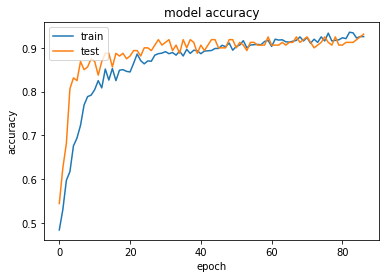

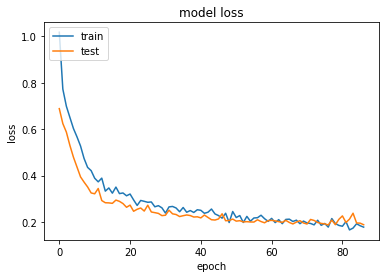

In [14]:
# list all data in history
print(histr.history.keys())
# summarize history for accuracy
plt.plot(histr.history['acc'])
plt.plot(histr.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histr.history['loss'])
plt.plot(histr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---

In [15]:
import matplotlib.image as mpimg

min1 = np.min(X_holdout)
max1 = np.max(X_holdout)
diff1 = max1 - min1
my_sum = lambda x: (x - min1)/diff1

X_holdout2 = my_sum(X_holdout)

In [16]:
Y_holdout

13      1
14      0
38      1
43      0
44      0
80      0
104     1
127     0
137     0
138     1
141     1
167     1
195     1
199     0
207     1
212     0
213     1
221     0
240     0
256     0
267     1
274     1
276     1
285     1
290     0
294     0
300     1
307     1
311     1
318     1
       ..
1363    1
1364    0
1373    1
1380    1
1394    0
1411    0
1435    0
1440    1
1445    1
1447    1
1460    1
1470    0
1488    0
1495    0
1504    1
1516    0
1525    0
1533    0
1537    0
1539    0
1541    0
1542    0
1549    0
1552    0
1559    0
1566    0
1567    0
1577    0
1590    0
1602    0
Name: is_iceberg, Length: 160, dtype: int64

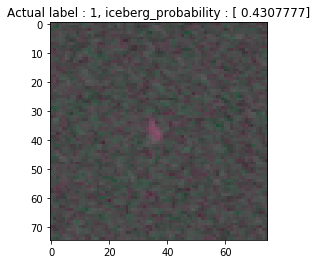

In [17]:
plt.imshow(X_holdout2[0], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[13])+ ","+" iceberg_probability : "+str(pred_valid[0])
plt.title(tl)

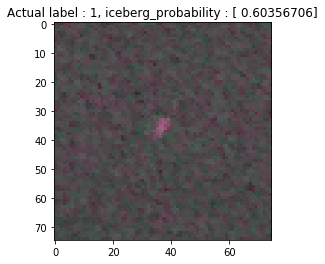

In [18]:
plt.imshow(X_holdout2[2], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[38])+ ","+" iceberg_probability : "+str(pred_valid[2])
plt.title(tl)

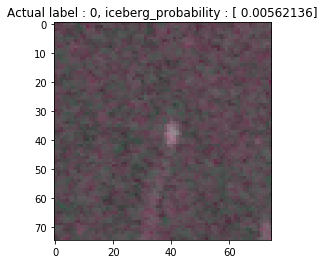

In [19]:
plt.imshow(X_holdout2[1], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[14])+ ","+" iceberg_probability : "+str(pred_valid[1])
plt.title(tl)

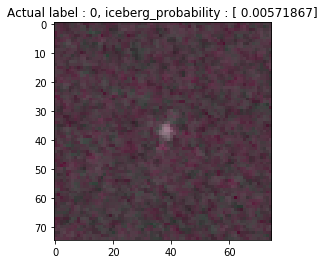

In [20]:
plt.imshow(X_holdout2[3], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[43])+ ","+" iceberg_probability : "+str(pred_valid[3])
plt.title(tl)

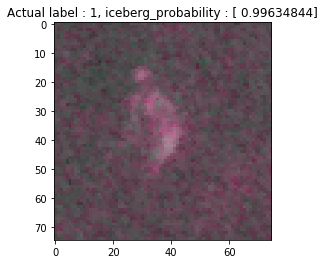

In [21]:
plt.imshow(X_holdout2[6], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[104])+ ","+" iceberg_probability : "+str(pred_valid[6])
plt.title(tl)

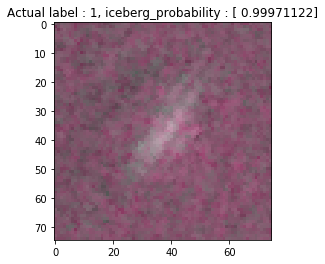

In [22]:
plt.imshow(X_holdout2[9], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[138])+ ","+" iceberg_probability : "+str(pred_valid[9])
plt.title(tl)